In [1]:
import  matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
import os
import shutil
import scipy as sp
import sys
from matplotlib import gridspec
from matplotlib import rc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import SymLogNorm
from matplotlib.colors import LogNorm

from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go

from openpmd_viewer import OpenPMDTimeSeries
from openpmd_viewer.addons import LpaDiagnostics

FontSize=25
FontSizeLabelAxis=25
rc('legend',fontsize=FontSize)
rc('xtick',labelsize=FontSize)
rc('ytick',labelsize=FontSize)
font = {'family' : 'normal',
        'size'   : FontSize}

rc('font', **font)
rc('text', usetex=True)

# scaling factors
mm=1e3
MV=1e-6
kV=1e-3
mu0 = sp.constants.mu_0

cms = sp.constants.speed_of_light

time = 3.36678*10**-11
zloc = time*cms
print(zloc)

0.010093352517452399


In [13]:
direc = 'gaussian/notphilippe/notpoynt/19022_many_vdiff/'
direc = 'gaussian/notphilippe/notpoynt/19280_final/'
direc = 'gaussian/notphilippe/notpoynt/19376_angle40/'
direc = 'gaussian/notphilippe/notpoynt/19559_angle42p5/'
direc = 'gaussian/notphilippe/notpoynt/19374_angle45/'
direc = 'gaussian/notphilippe/notpoynt/19951_angle45_moredom/'
#direc = 'gaussian/notphilippe/notpoynt/19560_angle47p5/'
#direc = 'gaussian/notphilippe/notpoynt/19377_angle50/'
# has to be 1 less than reported number of diags, because of 0
Nitera = 45 # 650 500

txtfile = '/lstr/sahara/aard/cphillips/'+direc+'diags/reducedfiles/reduced_diags.txt'

filedir = '/lstr/sahara/aard/cphillips/'+direc+'diags/slabmovingwarpx/'



In [3]:
ts = LpaDiagnostics(filedir)
N_iterations = len(ts.iterations)
print(N_iterations)

81


# Calculating Poynting Vector

In [7]:
# Which dumps we want to look at
dumpmin = 599
dumpmax = 684

dumpmin = 480
dumpmax = 548

dumpmin = 70
dumpmax = 140

dumpmin = 5
dumpmax = 80

# Get the cell we want
pvx = 0
pvy = 0
pvz = 100-(1+.4+.16) # structure len - cond_too_y

tslookat = np.arange(dumpmin,dumpmax+1,3)
print(tslookat)

[ 5  8 11 14 17 20 23 26 29 32 35 38 41 44 47 50 53 56 59 62 65 68 71 74
 77 80]


In [8]:
# let's just get the xyz min/max and PV for every ts first
alllocs = [] # going to be xsc, ysc, zsc
S_allx = []
S_ally = []
S_allz = []

for nit in tslookat:
    print(nit)

    it = ts.iterations[nit]
    
    Ez, info_Ez = ts.get_field( iteration=it,  field='E', coord='z',
                                slicing_dir='x', plot=False)
    Ex, info_Ex = ts.get_field( iteration=it,  field='E', coord='x',
                                slicing_dir='x', plot=False)
    Ey, info_Ey = ts.get_field( iteration=it,  field='E', coord='y',
                                slicing_dir='x', plot=False)
    Bx, info_Bx = ts.get_field( iteration=it,  field='B', coord='x',
                                slicing_dir='x', plot=False)
    By, info_By = ts.get_field( iteration=it,  field='B', coord='y',
                                slicing_dir='x', plot=False)
    Bz, info_Bz = ts.get_field( iteration=it,  field='B', coord='z',
                                slicing_dir='x',plot=False)
    alllocs.append([nit,info_Ez.xmin*mm, info_Ez.xmax*mm,info_Ez.ymin*mm, info_Ez.ymax*mm,info_Ez.zmin*mm, info_Ez.zmax*mm])
    print('Domain in z (mm): ',info_Ez.zmin*mm,info_Ez.zmax*mm)
    Sx = (1/mu0)*(Ey*Bz-Ez*By)
    Sy = (1/mu0)*(Ez*Bx-Ex*Bz)
    Sz = (1/mu0)*(Ex*By-Ey*Bx)
    S_allx.append(Sx)
    S_ally.append(Sy)
    S_allz.append(Sz)

    shapeSx = np.shape(Sx)
    print(shapeSx)
    shapeEz = np.shape(Ez)




5
Domain in z (mm):  81.0288302912045 107.07782933959749
(512, 256, 64)
8
Domain in z (mm):  81.58957195369433 107.63857100208732
(512, 256, 64)
11
Domain in z (mm):  82.15031361618416 108.19931266457715
(512, 256, 64)
14
Domain in z (mm):  82.711055278674 108.76005432706698
(512, 256, 64)
17
Domain in z (mm):  83.22082042639202 109.26981947478501
(512, 256, 64)
20
Domain in z (mm):  83.78156208888186 109.83056113727484
(512, 256, 64)
23
Domain in z (mm):  84.34230375137167 110.39130279976467
(512, 256, 64)
26
Domain in z (mm):  84.9030454138615 110.95204446225449
(512, 256, 64)
29
Domain in z (mm):  85.46378707635134 111.51278612474432
(512, 256, 64)
32
Domain in z (mm):  85.56574010589495 111.61473915428793
(512, 256, 64)
35
Domain in z (mm):  85.56574010589495 111.61473915428793
(512, 256, 64)
38
Domain in z (mm):  85.56574010589495 111.61473915428793
(512, 256, 64)
41
Domain in z (mm):  85.56574010589495 111.61473915428793
(512, 256, 64)
44
Domain in z (mm):  85.56574010589495 111.

### We now have the x,y,z components of the poynting vector at each grid point for each dump we specified
Future: \
change to just be info_Ez.xmin to info_Ez.xmax, since that's not different (see below)\
start below with x,y,z domain we want and then get all points within that plane

In [1]:
# in cm
r = 6

ys = np.arange(0,r+r/10,r/10)
print(ys)
zs = [np.sqrt(r**2 - ysi**2)+(100-(1+.4+.16)) for ysi in ys]
print(zs)

NameError: name 'np' is not defined

In [9]:
changelen = 0 # not including the last 2 cases, because they don't have the full range in z that we want 
lenarange = np.arange(len(tslookat)-changelen)

above = 3
below = 2

# Get the location of the center of the cells in x and y (same across dumps) and z for each dump
xsc = np.linspace(alllocs[0][1],alllocs[0][2],shapeEz[2])              # change to just be info_Ez.xmin to info_Ez.xmax, since that's not different at all? And then only save nit,zmin,zmax above?
ysc = np.linspace(alllocs[0][3],alllocs[0][4],shapeEz[1])
allzsc = [np.linspace(alllocs[i][5],alllocs[i][6],shapeEz[0]) for i in lenarange]

print('Domain: ')
print('xmin/max: ',info_Ez.xmin*mm, info_Ez.xmax*mm)
print('ymin/max: ',info_Ez.ymin*mm, info_Ez.ymax*mm)

# Get the index closest to x=y=0 and closest to structure exit in z; also get the actual location and print out for knowledge
indx = (np.abs(xsc - pvx)).argmin()
indy = (np.abs(ysc - pvy)).argmin()
indzs = [(np.abs(allzsc[i] - pvz)).argmin() for i in lenarange]
print(indzs)
locx = xsc[indx-below:indx+above]
locy = ysc[indy-below:indy+above]
loczs = [allzsc[i][indzs[i]-below:indzs[i]+above] for i in lenarange]
print('Goal location (x,y,z): ',pvx,pvy,pvz)
print('Index (x,y,z): ',indx,indy,indzs)
print('Actual location (x,y,z): ',locx, ' mm',locy,' mm') #,loczs)

print(np.shape(S_allx))
zeroPVx = [S_allx[i][indzs[i]-below:indzs[i]+above,indy-below:indy+above,indx-below:indx+above] for i in lenarange]
zeroPVy = [S_ally[i][indzs[i]-below:indzs[i]+above,indy-below:indy+above,indx-below:indx+above] for i in lenarange]
zeroPVz = [S_allz[i][indzs[i]-below:indzs[i]+above,indy-below:indy+above,indx-below:indx+above] for i in lenarange]

print(np.shape(zeroPVx))
print(np.shape(zeroPVy))
print(np.shape(zeroPVz))

print(locx,locy)
print([np.mean(loczs) for i in np.arange(len(locx))])


avgPVx = np.mean(zeroPVx,axis=0)
avgPVy = np.mean(zeroPVy,axis=0)
avgPVz = np.mean(zeroPVz,axis=0)
print(np.shape(avgPVx))



Domain: 
xmin/max:  -1.5356249999999998 1.5356249999999998
ymin/max:  -10.4755859375 1.9755859374999998
[342, 331, 320, 309, 299, 288, 277, 266, 255, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253]
Goal location (x,y,z):  0 0 98.44
Index (x,y,z):  31 215 [342, 331, 320, 309, 299, 288, 277, 266, 255, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253]
Actual location (x,y,z):  [-0.121875 -0.073125 -0.024375  0.024375  0.073125]  mm [-0.07519531 -0.02636719  0.02246094  0.07128906  0.12011719]  mm
(26, 512, 256, 64)
(26, 5, 5, 5)
(26, 5, 5, 5)
(26, 5, 5, 5)
[-0.121875 -0.073125 -0.024375  0.024375  0.073125] [-0.07519531 -0.02636719  0.02246094  0.07128906  0.12011719]
[98.46279834316198, 98.46279834316198, 98.46279834316198, 98.46279834316198, 98.46279834316198]
(5, 5, 5)


In [10]:
# Prepare data for plotting below; specifically along the structure exit
# get x,y,z 
xplotS = locx
yplotS = locy
zplotS = np.diagonal(loczs)
print(zplotS)
print(np.shape(xplotS),np.shape(yplotS),np.shape(zplotS))

# z-x Poynting Vector data
PVxz_z = np.diagonal(avgPVz[:,2,:])
PVxz_x = np.diagonal(avgPVx[:,2,:])

# z-y Poynting Vector data
PVyz_z = np.diagonal(avgPVz[:,:,1])
PVyz_y = np.diagonal(avgPVy[:,:,1])

print('xz_x, yz_y, xz_z, yz_z')
print(PVxz_x)
print(PVyz_y)
print(PVxz_z)
print(PVyz_z)

angley = np.arctan(PVyz_y/(-1*PVyz_z))
angleydeg = angley*180/np.pi
print('Angle wrt y axis from bottom to top')
print(angleydeg)

anglex = np.arctan(PVxz_x/PVxz_z)
anglexdeg = anglex*180/np.pi
print('Angle wrt x axis from bottom to top')
print(anglexdeg)

[98.36084531 98.41182183 98.46279834 98.51377486 98.56475137]
(5,) (5,) (5,)
xz_x, yz_y, xz_z, yz_z
[ 2.37383613e+09  1.37801398e+09  4.38959262e+08 -4.07552890e+08
 -1.12147042e+09]
[-2.80083797e+10 -2.79867305e+10 -2.79439497e+10 -2.78635023e+10
 -2.77005478e+10]
[9.07471391e+09 9.51216880e+09 1.01524462e+10 1.09358724e+10
 1.18266838e+10]
[1.17297263e+10 1.09978399e+10 1.03314139e+10 9.68855072e+09
 9.12797976e+09]
Angle wrt y axis from bottom to top
[67.27638324 68.5468494  69.70968041 70.82668287 71.76173703]
Angle wrt x axis from bottom to top
[14.6594069   8.24300992  2.47574406 -2.13428415 -5.41689989]


# Single dump calculations

In [14]:
#ts = LpaDiagnostics(filedir)

#N_iterations = len(ts.iterations)
#print(N_iterations)
if Nitera==-1:
   it = ts.iterations[N_iterations-1]
else:
   it = ts.iterations[Nitera]

# -------------------------------------------------------------------------
# retrieve the data from the hdf5 file for the electric and magnetic fields
# -------------------------------------------------------------------------
Ez, info_Ez = ts.get_field( iteration=it,  field='E', coord='z',
                            slicing_dir='x', plot=False)
Ex, info_Ex = ts.get_field( iteration=it,  field='E', coord='x',
                            slicing_dir='x', plot=False)
Ey, info_Ey = ts.get_field( iteration=it,  field='E', coord='y',
                            slicing_dir='x', plot=False)
Bx, info_Bx = ts.get_field( iteration=it,  field='B', coord='x',
                            slicing_dir='x', plot=False)
By, info_By = ts.get_field( iteration=it,  field='B', coord='y',
                            slicing_dir='x', plot=False)
Bz, info_Bz = ts.get_field( iteration=it,  field='B', coord='z',
                            slicing_dir='x',plot=False)
xf, yf, zf, px, py, pz = ts.get_particle( ['x','y','z','ux','uy','uz'],  species='myparticle', iteration=it)



shapeEz= np.shape(Ez)
print('z, y, x grid size: ',shapeEz)
absmax=MV*max(np.max(np.max(np.abs(Ez))),np.abs(np.min(np.min(np.abs(Ez)))))

xsc=np.linspace(info_Ez.xmin*mm, info_Ez.xmax*mm, shapeEz[2])
ysc=np.linspace(info_Ez.ymin*mm, info_Ez.ymax*mm, shapeEz[1])
zsc=np.linspace(info_Ez.zmin*mm, info_Ez.zmax*mm, shapeEz[0])


print('Domain:')
print('xmin/max: ',info_Ez.xmin*mm, info_Ez.xmax*mm)
print('ymin/max: ',info_Ez.ymin*mm, info_Ez.ymax*mm)
print('zmin/max: ',info_Ez.zmin*mm, info_Ez.zmax*mm)

print('zmean: ',np.round(np.mean(zf),6)*mm,' mm')
print('last particle z: ',np.round(np.min(zf),6)*mm,' mm')
print('x=y=0 structure exit in z: ',100-(1+.4+.16), ' mm')

print('first particle z: ',np.round(np.max(zf),6)*mm,' mm')

z, y, x grid size:  (512, 256, 64)
Domain:
xmin/max:  -1.5356249999999998 1.5356249999999998
ymin/max:  -10.4755859375 1.9755859374999998
zmin/max:  85.56574010589495 111.61473915428793
zmean:  111.41900000000001  mm
last particle z:  111.19900000000001  mm
x=y=0 structure exit in z:  98.44  mm
first particle z:  111.58800000000001  mm


zrange:  85.56574010589495 110  mm
zindexmin:  0  zindexmax:  480
index of y=0:  215
yloc we are able to get:  0.0224609375  mm
Angle wrt x axis from bottom to top
[14.6594069   8.24300992  2.47574406 -2.13428415 -5.41689989]
(64, 480)


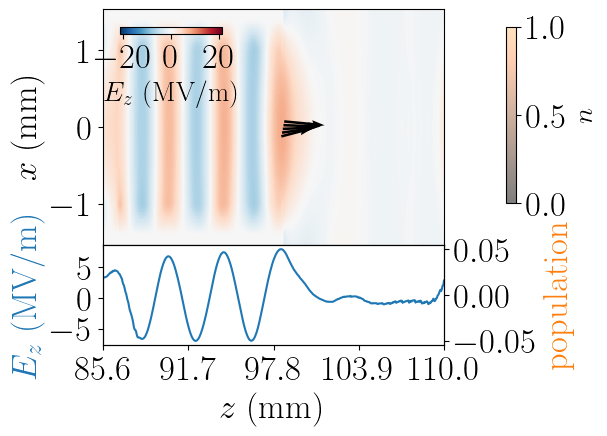

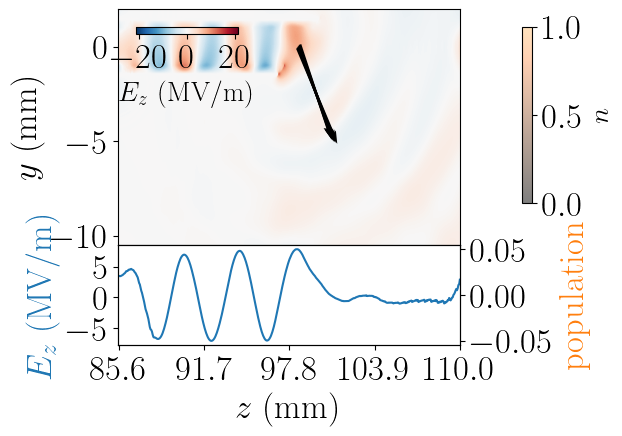

In [17]:
# PLOT POYNTING VECTOR?
pvplot = 2
pv2scale = 100000000000 #5000000000 #
#avg_PVn = [ 0.06160164, -0.51742454,  0.38209828] 
#avg_PV = [   357.15761471, -30179.31971494,  13167.58016861]

zlow = info_Ez.zmin*mm # 60
zhigh = 110 #info_Ez.zmax*mm   #109.6
mult = 5 #8
lenz = zhigh-zlow
xticklist = np.arange(zlow,zhigh+lenz/2,lenz/4)
xticklist = [round(i,1) for i in xticklist]
indexmin = (np.abs(zsc - zlow)).argmin()
indexmax = (np.abs(zsc - zhigh)).argmin()
if indexmin==0:
    indexmax = indexmax + 1
print('zrange: ', zlow, zhigh, ' mm')
print('zindexmin: ',indexmin,' zindexmax: ',indexmax)

# Center in y for offset structure; always want on axis
yloc = 0
index_y0 = (np.abs(ysc - yloc)).argmin()
print('index of y=0: ',index_y0)
print('yloc we are able to get: ',ysc[index_y0], ' mm')

# generate a plot of the Ez wake in (z,y) with lineout of Ez
fig=plt.figure(9999)
gs1 = gridspec.GridSpec(11, 13)
ax1 = fig.add_subplot(gs1[0:7,1:10])
ax2 = fig.add_subplot(gs1[7:10,1:10], sharex =ax1)
ax3 = fig.add_subplot(gs1[0:7,11:12])


# record Ez in the (z,x) plane for y=0
Ezslice=Ez[indexmin:indexmax,index_y0,:].transpose()*MV # gets the x=0 slice
Ezslice = np.flipud(Ezslice)
shapeEzslice = np.shape(Ezslice)

# plot slice (upper plot with red and blue lines)
imField=ax1.imshow(Ezslice,extent=[zlow,zhigh, info_Ez.xmin*mm,info_Ez.xmax*mm],
                   cmap='RdBu_r', vmin=-absmax/mult, vmax=absmax/mult, aspect='auto')
cbaxes = inset_axes(ax1, width="30%", height="3%", loc=2)
cbar1  = fig.colorbar(imField, cax=cbaxes, orientation='horizontal').set_label(label=r'$E_z$ (MV/m)',size=20)
ax1.set_ylabel(r'$x$ (mm)', fontsize=FontSizeLabelAxis)

# record particle and plot a histogram on top of 3d of Ez - NEED TO ADJUST AXES FOR THIS
particles=ax1.hexbin(zf*mm, xf*mm, gridsize=200,extent=[zlow,zhigh, info_Ez.xmin*mm,info_Ez.xmax*mm], cmap='copper', alpha=0.5,  mincnt=5)
ax3.axis('off')
cbaxes2 = inset_axes(ax3, width="30%", height="75%", loc=2)
cbar2 = fig.colorbar(particles, cax=cbaxes2).set_label(label=r'$n$ ',size=20)

if pvplot == 1:
    pv = ax1.quiver(locz,locx,PV[2],PV[0],color='g',scale=3)
elif pvplot ==2:
    pv = ax1.quiver(zplotS,xplotS,PVxz_z,PVxz_x,color='k',scale=pv2scale)
    print('Angle wrt x axis from bottom to top')
    print(anglexdeg)

    


# Line plot of Ez plus histogram of the population on lower plot
zsca=np.linspace(zlow,zhigh, indexmax-indexmin)
print(np.shape(Ezslice))
ax2.plot (zsca,Ezslice[int(shapeEzslice[0]/2),:]) # gets the y=0 slice
ax2.set_xlabel(r'$z$ (mm)', fontsize=FontSizeLabelAxis)
ax2.set_ylabel(r'$E_z$ (MV/m) ', fontsize=FontSizeLabelAxis, color="C0")
ax2.set_xticks(xticklist)
ax22 = ax2.twinx()
ax22.hist(zf*mm,shapeEz[0], range=(zlow,zhigh),alpha=0.3, color='C1')
ax22.set_ylabel(r'population', fontsize=FontSizeLabelAxis, color="C1")

# Set up the plots
plt.setp(ax1.get_xticklabels(), visible=False)
# remove last tick label for the second subplot
yticks = ax2.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)
#plt.subplots_adjust(hspace=.0)

# Save the plot to be viewed
#plt.savefig(save_dir+fig9999)
#plt.savefig(save_dir+fig9999p,dpi=600)
#plt.savefig(plotnms[pn]+'x.png')
plt.show()



#-------------------------------------------------------------------------
# record Ez in the (z,y) plane for x=0
fig=plt.figure(9998)
gs1 = gridspec.GridSpec(11, 13)
ax1 = fig.add_subplot(gs1[0:7,1:10])
ax2 = fig.add_subplot(gs1[7:10,1:10], sharex =ax1)
ax3 = fig.add_subplot(gs1[0:7,11:12])

# record Ez in the (z,y) plane for x=0
Ezslice=Ez[indexmin:indexmax,:,int(shapeEz[2]/2)].transpose()*MV # gets the x=0 sliceplt.gca().invert_yaxis()
Ezslice = np.flipud(Ezslice)
shapeEzslice = np.shape(Ezslice)

# plot slice (upper plot with red and blue lines)
imField=ax1.imshow(Ezslice,extent=[zlow,zhigh, info_Ez.ymin*mm,info_Ez.ymax*mm],
                   cmap='RdBu_r', vmin=-absmax/mult, vmax=absmax/mult, aspect='auto')
cbaxes = inset_axes(ax1, width="30%", height="3%", loc=2)
cbar1  = fig.colorbar(imField, cax=cbaxes, orientation='horizontal').set_label(label=r'$E_z$ (MV/m)',size=20)
ax1.set_ylabel(r'$y$ (mm)', fontsize=FontSizeLabelAxis)
plt.gca().invert_yaxis()

# record particle and plot a histogram on top of 3d of Ez
particles=ax1.hexbin(zf*mm, yf*mm, gridsize=200,extent=[zlow,zhigh, info_Ez.ymin*mm,info_Ez.ymax*mm], cmap='copper', alpha=0.5,  mincnt=5)
ax3.axis('off')
cbaxes2 = inset_axes(ax3, width="30%", height="75%", loc=2)
cbar2 = fig.colorbar(particles, cax=cbaxes2).set_label(label=r'$n$ ',size=20)

if pvplot == 1:
    pv = ax1.quiver(locz,locy,PV[2],PV[1],color='g',scale=3)
elif pvplot ==2:
    pv = ax1.quiver(zplotS,yplotS,PVyz_z,PVyz_y,color='k',scale=pv2scale)
#    print('Angle wrt y axis from bottom to top')
#    print(angleydeg)


#zplotS,xplotS,avgPVz[1,:],avgPVx[1,:]

# Line plot of Ez plus histogram of the population on lower plot
zscb=np.linspace(zlow,zhigh, indexmax-indexmin)
ax2.plot (zscb,Ezslice[np.shape(Ezslice)[0]-index_y0,:]) #int(shapeEzslice[0]/2),:]) # Ez slice has shape (ylen,zlen)
#ax2.plot (zscb,Ey[16,48,:]*1e-6)
#ax2.plot (zscb,Ex[16,48,:]*1e-6)
ax2.set_xlabel(r'$z$ (mm)', fontsize=FontSizeLabelAxis)
ax2.set_ylabel(r'$E_z$ (MV/m) ', fontsize=FontSizeLabelAxis, color="C0")
ax2.set_xticks(xticklist)
ax22 = ax2.twinx()
ax22.hist(zf*mm,shapeEz[0], range=(zlow,zhigh),alpha=0.3, color='C1')
ax22.set_ylabel(r'population', fontsize=FontSizeLabelAxis, color="C1")

# Set up the plots
plt.setp(ax1.get_xticklabels(), visible=False)
# remove last tick label for the second subplot
yticks = ax2.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)
#plt.subplots_adjust(hspace=.0)

# Save the plot to be viewed
#plt.savefig(save_dir+fig9998)
#plt.savefig(save_dir+fig9998p,dpi=600)
#plt.savefig(plotnms[pn]+'y.png')
plt.show()



In [23]:
print('Angle wrt y axis')
angley = np.arctan(PVyz_y[0]/PVyz_z[0])*180/np.pi
print(PVyz_z)
print(PVyz_y)
print(angley)
print(-PVyz_y[0])


Angle wrt y axis


NameError: name 'PVyz_y' is not defined

In [ ]:
# poynting vector calc
# poynting vector from this point
pvx = 0
pvy = 0
pvz = 100-(1+.4+.16) # structure len - cond_too_y
print('Goal location (x,y,z): ',pvx,pvy,pvz)

# get closest (x,y,z) index
indx = (np.abs(xsc - pvx)).argmin()
indy = (np.abs(ysc - pvy)).argmin()
indz = (np.abs(zsc - pvz)).argmin()
locx = xsc[indx]
locy = ysc[indy]
locz = zsc[indz]
print('Index (x,y,z): ',indx,indy,indz)
print('Actual location (x,y,z): ',locx,locy,locz)

print(np.shape(Ex),np.shape(Ey),np.shape(Ez),np.shape(Bx),np.shape(By),np.shape(Bz))

Ex_0 = Ex[indz,indy,indx]
Ey_0 = Ey[indz,indy,indx]
Ez_0 = Ez[indz,indy,indx]
Bx_0 = Bx[indz,indy,indx]
By_0 = By[indz,indy,indx]
Bz_0 = Bz[indz,indy,indx]

# poynting vector is (1/mu_0) E_vec X B_vec
pv_x = (1/mu0)*(Ey_0*Bz_0 - Ez_0*By_0)*MV
pv_y = (1/mu0)*(Ez_0*Bx_0 - Ex_0*Bz_0)*MV
pv_z = (1/mu0)*(Ex_0*By_0 - Ey_0*Bx_0)*MV
print(pv_x,pv_y,pv_z, 'MV')
PVx = np.linspace(0,pv_x,100)
PVy = np.linspace(0,pv_y,100)
PVz = np.linspace(0,pv_z,100)
#PV = [[0,pv_x],[0,pv_y],[0,pv_z]]

tot = np.sqrt(pv_x**2 + pv_y**2 + pv_z**2)
print(tot)

PVnx = pv_x/tot
PVny = pv_y/tot
PVnz = pv_z/tot
PV = [pv_x,pv_y,pv_z] # not normalized to 1; not unit vector
PV = [PVnx,PVny,PVnz] # normalized to 1; unit vector
print(PV)

In [15]:
lenarange = np.arange(len(tslookat))

shapeEz = np.shape(allfields[0][3])
print('z, y, x grid size: ',shapeEz)
absmax=MV*max(np.max(np.max(np.abs(allfields[0][3]))),np.abs(np.min(np.min(np.abs(allfields[0][3])))))



# We don't just want the closest index, but we want the surrounding indices as well; let's not change z for now 
xindices = np.arange(indx-1,indx+3)
print(xsc[indx-1:indx+3])
print(ysc[indy-1:indy+3])


zeroFields = [[allfields[i][0],allfields[i][1][indzs[i],indy,indx],allfields[i][2][indzs[i],indy,indx],allfields[i][3][indzs[i],indy,indx],
               allfields[i][4][indzs[i],indy,indx],allfields[i][5][indzs[i],indy,indx],allfields[i][6][indzs[i],indy,indx]] for i in lenarange]


# poynting vector calc
# poynting vector is (1/mu_0) E_vec X B_vec
pv_x = [(1/mu0)*(zeroFields[i][2]*zeroFields[i][6] - zeroFields[i][3]*zeroFields[i][5])*MV for i in lenarange]
pv_y = [(1/mu0)*(zeroFields[i][3]*zeroFields[i][4] - zeroFields[i][1]*zeroFields[i][6])*MV for i in lenarange]
pv_z = [(1/mu0)*(zeroFields[i][1]*zeroFields[i][5] - zeroFields[i][2]*zeroFields[i][4])*MV for i in lenarange]

avgPVx = np.mean(pv_x)
avgPVy = np.mean(pv_y)
avgPVz = np.mean(pv_z)

avg_PV = [avgPVx,avgPVy,avgPVz]
print(avg_PV)

tots = [np.sqrt(pv_x[i]**2 + pv_y[i]**2 + pv_z[i]**2) for i in lenarange]
PVnxs = [pv_x[i]/tots[i] for i in lenarange]
PVnys = [pv_y[i]/tots[i] for i in lenarange]
PVnzs = [pv_z[i]/tots[i] for i in lenarange]

PVns = [[PVnxs[i],PVnys[i],PVnzs[i]] for i in lenarange]

avg_PVn = np.mean(PVns,axis=0)

z, y, x grid size:  (512, 128, 64)
Domain: 
xmin/max:  -1.5356249999999998 1.5356249999999998
ymin/max:  -5.470703124999999 1.9707031250000007
zmin/max:  90.4085090092162 116.4575080576092
[319, 315, 310, 305, 300, 296, 291, 286, 281, 277, 272, 267, 262, 258, 253, 248, 244, 239, 234, 229, 225, 220, 215, 210, 206, 201, 196, 191, 187, 182, 177, 173, 168, 163, 158, 154, 149, 144, 139, 135, 130, 125, 120, 116, 111, 106, 102, 97, 92, 87, 83, 78, 73, 68, 64, 59, 54, 49, 45, 40, 35, 31, 26, 21, 16, 12, 7, 2, 0]
Goal location (x,y,z):  0 0 98.44
Index (x,y,z):  31 93 [319, 315, 310, 305, 300, 296, 291, 286, 281, 277, 272, 267, 262, 258, 253, 248, 244, 239, 234, 229, 225, 220, 215, 210, 206, 201, 196, 191, 187, 182, 177, 173, 168, 163, 158, 154, 149, 144, 139, 135, 130, 125, 120, 116, 111, 106, 102, 97, 92, 87, 83, 78, 73, 68, 64, 59, 54, 49, 45, 40, 35, 31, 26, 21, 16, 12, 7, 2, 0]
Actual location (x,y,z):  -0.024375000000000036  mm -0.021484374999999112  mm [98.46279834316216, 98.462798343162

In [10]:
# allPV
dumpmin = 599
dumpmax = 684






all_PVn = [] # unit vector
all_PV = [] # not normalized

print(np.arange(dumpmin,dumpmax+1))

# let's just get the PV for every ts first
for nit in np.arange(dumpmin,dumpmax+1):
    print(nit)
    ts = LpaDiagnostics(filedir)
    
    N_iterations = len(ts.iterations)
    it = ts.iterations[nit]
    
    Ez, info_Ez = ts.get_field( iteration=it,  field='E', coord='z',
                                slicing_dir='x', plot=False)
    Ex, info_Ex = ts.get_field( iteration=it,  field='E', coord='x',
                                slicing_dir='x', plot=False)
    Ey, info_Ey = ts.get_field( iteration=it,  field='E', coord='y',
                                slicing_dir='x', plot=False)
    Bx, info_Bx = ts.get_field( iteration=it,  field='B', coord='x',
                                slicing_dir='x', plot=False)
    By, info_By = ts.get_field( iteration=it,  field='B', coord='y',
                                slicing_dir='x', plot=False)
    Bz, info_Bz = ts.get_field( iteration=it,  field='B', coord='z',
                                slicing_dir='x',plot=False)
    
    
    shapeEz= np.shape(Ez)
    print('z, y, x grid size: ',shapeEz)
    absmax=MV*max(np.max(np.max(np.abs(Ez))),np.abs(np.min(np.min(np.abs(Ez)))))
    
    xsc=np.linspace(info_Ez.xmin*mm, info_Ez.xmax*mm, shapeEz[2])
    ysc=np.linspace(info_Ez.ymin*mm, info_Ez.ymax*mm, shapeEz[1])
    zsc=np.linspace(info_Ez.zmin*mm, info_Ez.zmax*mm, shapeEz[0])
    
    print('Domain:')
    print('xmin/max: ',info_Ez.xmin*mm, info_Ez.xmax*mm)
    print('ymin/max: ',info_Ez.ymin*mm, info_Ez.ymax*mm)
    print('zmin/max: ',info_Ez.zmin*mm, info_Ez.zmax*mm)
    
    # poynting vector calc
    # poynting vector from this point
    pvx = 0
    pvy = 0
    pvz = 100-(1+.4+.16) # structure len - cond_too_y
    print('Goal location (x,y,z): ',pvx,pvy,pvz)
    
    # get closest (x,y,z) index
    indx = (np.abs(xsc - pvx)).argmin()
    indy = (np.abs(ysc - pvy)).argmin()
    indz = (np.abs(zsc - pvz)).argmin()
    locx = xsc[indx]
    locy = ysc[indy]
    locz = zsc[indz]
    print('Index (x,y,z): ',indx,indy,indz)
    print('Actual location (x,y,z): ',locx,locy,locz)
    
    
    Ex_0 = Ex[indz,indy,indx]
    Ey_0 = Ey[indz,indy,indx]
    Ez_0 = Ez[indz,indy,indx]
    Bx_0 = Bx[indz,indy,indx]
    By_0 = By[indz,indy,indx]
    Bz_0 = Bz[indz,indy,indx]
    
    # poynting vector is (1/mu_0) E_vec X B_vec
    pv_x = (1/mu0)*(Ey_0*Bz_0 - Ez_0*By_0)*MV
    pv_y = (1/mu0)*(Ez_0*Bx_0 - Ex_0*Bz_0)*MV
    pv_z = (1/mu0)*(Ex_0*By_0 - Ey_0*Bx_0)*MV
    print(pv_x,pv_y,pv_z, 'MV')
    PVx = np.linspace(0,pv_x,100)
    PVy = np.linspace(0,pv_y,100)
    PVz = np.linspace(0,pv_z,100)
    
    tot = np.sqrt(pv_x**2 + pv_y**2 + pv_z**2)
    print(tot)
    
    PVnx = pv_x/tot
    PVny = pv_y/tot
    PVnz = pv_z/tot
    PVn = [PVnx,PVny,PVnz]
    PV = [pv_x,pv_y,pv_z]
    all_PVn.append(PVn)
    all_PV.append(PV)

# calc average poynting vector
avg_PVn = np.mean(all_PVn,axis=0)
avg_PV = np.mean(all_PV,axis=0)
print(avg_PVn,avg_PV)

[599 600 601 602 603 604 605 606 607 608 609 610 611 612 613 614 615 616
 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632 633 634
 635 636 637 638 639 640 641 642 643 644 645 646 647 648 649 650 651 652
 653 654 655 656 657 658 659 660 661 662 663 664 665 666 667 668 669 670
 671 672 673 674 675 676 677 678 679 680 681 682 683 684]
599


KeyboardInterrupt: 

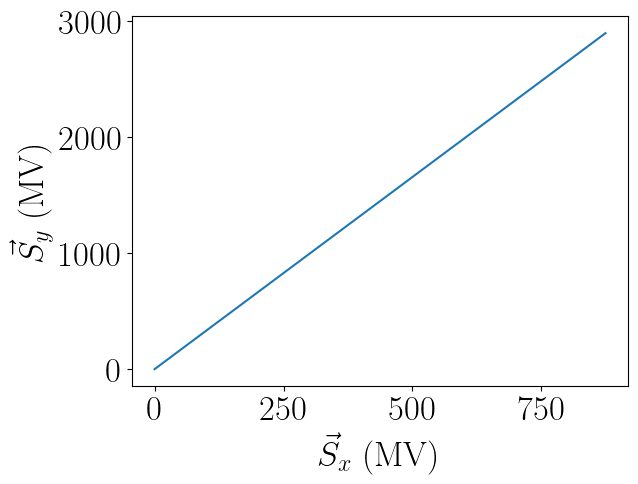

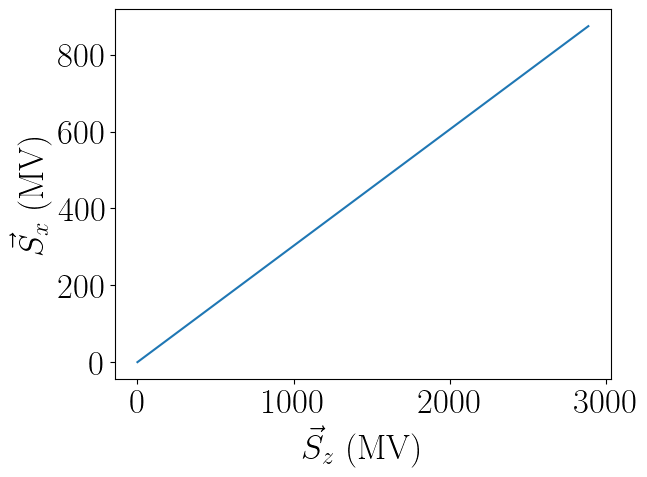

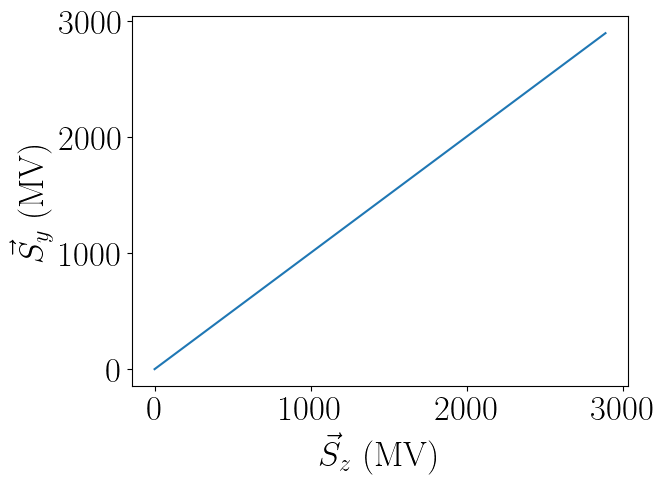

In [59]:
plt.plot(PVx,PVy)
plt.xlabel(r'$\vec{S}_x$ (MV)')
plt.ylabel(r'$\vec{S}_y$ (MV)')
plt.show()

plt.plot(PVz,PVx)
plt.xlabel(r'$\vec{S}_z$ (MV)')
plt.ylabel(r'$\vec{S}_x$ (MV)')
plt.show()

plt.plot(PVz,PVy)
plt.xlabel(r'$\vec{S}_z$ (MV)')
plt.ylabel(r'$\vec{S}_y$ (MV)')
plt.show()



